In [1]:
import tensorflow.keras.backend as K
import math
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

In [2]:
class LRFinder:
    """
    Learning rate range test detailed in Cyclical Learning Rates for Training
    Neural Networks by Leslie N. Smith. The learning rate range test is a test
    that provides valuable information about the optimal learning rate. During
    a pre-training run, the learning rate is increased linearly or
    exponentially between two boundaries. The low initial learning rate allows
    the network to start converging and as the learning rate is increased it
    will eventually be too large and the network will diverge.
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.learning_rates = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

        loss = logs['loss']
        self.losses.append(loss)

        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, dataset, start_lr, end_lr, epochs=1,
             steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            raise Exception('To correctly train on the datagenerator,'
                            '`steps_per_epoch` cannot be None.'
                            'You can calculate it as '
                            '`np.ceil(len(TRAINING_LIST) / BATCH)`')

        self.lr_mult = (float(end_lr) /
                        float(start_lr)) ** (float(1) /
                                             float(epochs * steps_per_epoch))
        initial_weights = self.model.get_weights()

        original_lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                  logs: self.on_batch_end(batch, logs))

        self.model.fit(dataset,
                       epochs=epochs, callbacks=[callback], **kw_fit)
        self.model.set_weights(initial_weights)

        K.set_value(self.model.optimizer.lr, original_lr)

    def get_learning_rates(self):
        return(self.learning_rates)

    def get_losses(self):
        return(self.losses)

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.learning_rates)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.learning_rates[n_skip_beginning:-n_skip_end][best_der_idx]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


In [6]:
BATCH = 128

lr_finder = LRFinder(model)
STEPS_PER_EPOCH = np.ceil(len(ds_train) / BATCH)
lr_finder.find(ds_train, start_lr=1e-6, end_lr=1, epochs=5,
               steps_per_epoch=STEPS_PER_EPOCH)
learning_rates = lr_finder.get_learning_rates()
losses = lr_finder.get_losses()


Epoch 1/5
469/469 [==============================] - 6s 151us/step - loss: 8.6113 - sparse_categorical_accuracy: 0.3306


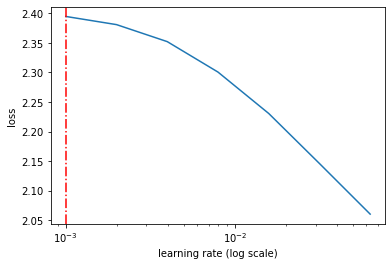

In [8]:
def plot_loss(learning_rates, losses, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
    f, ax = plt.subplots()
    ax.set_ylabel("loss")
    ax.set_xlabel("learning rate (log scale)")
    ax.plot(learning_rates[n_skip_beginning:-n_skip_end],
            losses[n_skip_beginning:-n_skip_end])
    ax.set_xscale(x_scale)
    return(ax)

axs = plot_loss(learning_rates,losses)
axs.axvline(x=lr_finder.get_best_lr(sma=20), c='r', linestyle='-.')


In [10]:
best_lr = lr_finder.get_best_lr(sma=20)
K.set_value(model.optimizer.lr, best_lr)
print(model.optimizer.lr)


<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0009999999>


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=0, patience=3)


In [14]:
model.fit(ds_train, epochs=10, validation_data=ds_test, callbacks=[earlystop_callback])
model.evaluate(ds_test)


Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.4431 - sparse_categorical_accuracy: 0.8799 - val_loss: 0.2179 - val_sparse_categorical_accuracy: 0.9384


Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 0.1913 - sparse_categorical_accuracy: 0.9460 - val_loss: 0.1684 - val_sparse_categorical_accuracy: 0.9514


Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 0.1404 - sparse_categorical_accuracy: 0.9600 - val_loss: 0.1265 - val_sparse_categorical_accuracy: 0.9610


Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.1102 - sparse_categorical_accuracy: 0.9680 - val_loss: 0.1119 - val_sparse_categorical_accuracy: 0.9650


Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0893 - sparse_categorical_accuracy: 0.9745 - val_loss: 0.0952 - val_sparse_categorical_accuracy: 0.9703


Epoch 6/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0742 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.0892 - val_sparse_categorical_accuracy: 0.9729


Epoch 7/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0624 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.0838 - val_sparse_categorical_accuracy: 0.9736


Epoch 8/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9850 - val_loss: 0.0835 - val_sparse_categorical_accuracy: 0.9734


Epoch 9/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0458 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.0777 - val_sparse_categorical_accuracy: 0.9757


Epoch 10/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0392 - sparse_categorical_accuracy: 0.9887 - val_loss: 0.0752 - val_sparse_categorical_accuracy: 0.9772


79/79 [==============================] - 0s 2ms/step - loss: 0.0752 - sparse_categorical_accuracy: 0.9772


[0.07521282136440277, 0.9771999716758728]

In [15]:
model.save('saved_model/model')


INFO:tensorflow:Assets written to: saved_model/model/assets


INFO:tensorflow:Assets written to: saved_model/model/assets


In [16]:
model = tf.keras.models.load_model('saved_model/model')

def predict(image, model=model):
    img = tf.keras.preprocessing.image.load_img(
        image, target_size=(28, 28), color_mode='grayscale')
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.expand_dims(img, 0)
    pred = model.predict(img)
    score = tf.nn.softmax(pred[0])
    return np.argmax(score)

